<a href="https://colab.research.google.com/github/zhukuixi/Udacity_DataScientistNanoDegree/blob/main/H%26M%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',50)

In [89]:
articles = pd.read_csv('/content/drive/MyDrive/H&M_data/data/articles.csv')
customers = pd.read_csv('/content/drive/MyDrive/H&M_data/data/customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/H&M_data/data/transactions_train.csv')

### [Article]:Word Count Barplot Visualization

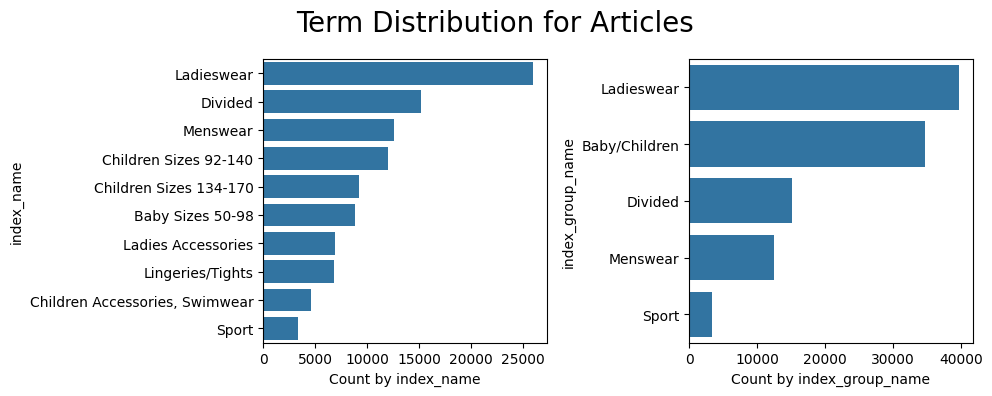

In [46]:
target_col = ['index_name','index_group_name']
fig,ax = plt.subplots(1,len(target_col),figsize=(10,4))
fig.suptitle('Term Distribution for Articles',size=20)
for i in range(len(target_col)):
  feature = target_col[i]
  temp = articles[feature].value_counts().reset_index()
  temp.columns=[feature,'frequency']
  sns.barplot(data=temp,x='frequency',y=feature,ax=ax[i])
  ax[i].set_ylabel(feature)
  ax[i].set_xlabel(f'Count by {feature}')
plt.tight_layout()
plt.show()

In [54]:
plt.figure(1,figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

## [Customer]: Customer Age Distribution

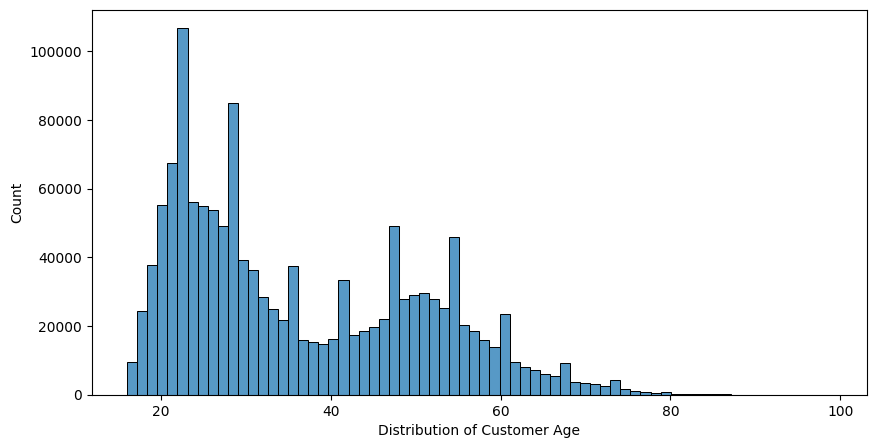

In [70]:
fig,ax = plt.subplots(figsize=(10,5))
sns.histplot(customers['age'],bins=70,ax=ax)
ax.set_xlabel('Distribution of Customer Age')
plt.show()

## [Customer]: Customer Member Status

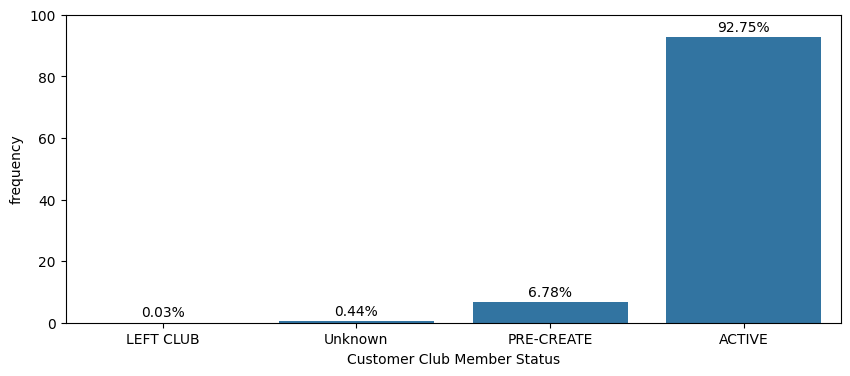

In [87]:
temp = customers['club_member_status'].value_counts(dropna=False).reset_index()
temp.columns=['club member status','frequency']
temp.sort_values('frequency',inplace=True)
temp['club member status'].replace(np.nan,'Unknown',inplace=True)
temp['frequency'] = (100*temp['frequency']/temp['frequency'].sum()).round(2)
fig,ax = plt.subplots(figsize=(10,4))
sns.barplot(data=temp,x='club member status',y='frequency',ax=ax)
ax.set_xlabel('Customer Club Member Status')
ax.set_ylim(0,100)

# Add numbers on top of each bar
for i, v in enumerate(temp['frequency']):
    plt.text(i, v + 1, f'{v}%', ha='center', va='bottom')
plt.show()



## [Transactions]: Transaction Price Ditribution in Different Sale Channel

In [108]:
d1 = transactions.query('sales_channel_id==1')['price'].sample(10000)
d2 = transactions.query('sales_channel_id==2')['price'].sample(10000)
d3 = transactions['price'].sample(10000)

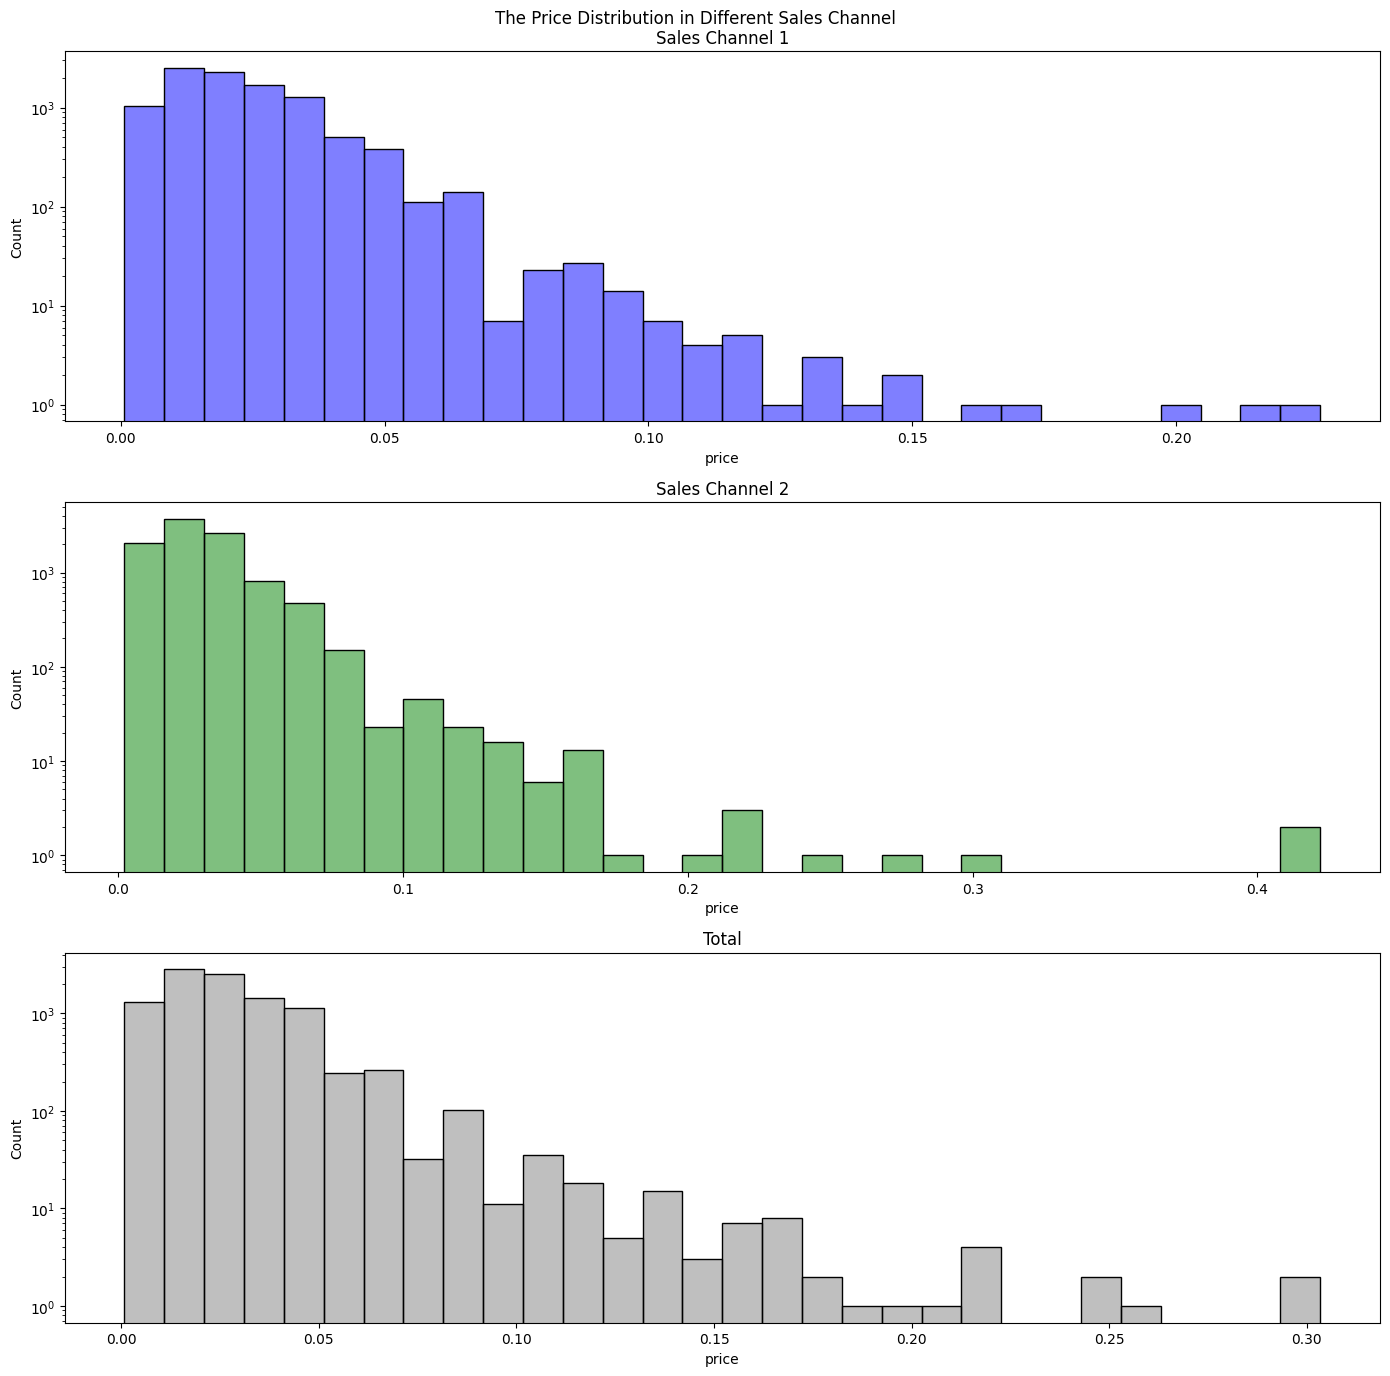

In [114]:
fig,ax = plt.subplots(3,1,figsize=(14,14))
# Sales Channel 1
fig.suptitle('The Price Distribution in Different Sales Channel')
sns.histplot(d1,ax=ax[0],bins=30,alpha=0.5,color='blue')
ax[0].set_title('Sales Channel 1')
ax[0].set_yscale('log')
sns.histplot(d2,ax=ax[1],bins=30,alpha=0.5,color='green')
ax[1].set_title('Sales Channel 2')
ax[1].set_yscale('log')
sns.histplot(d3,ax=ax[2],bins=30,alpha=0.5,color='grey')
ax[2].set_title('Total')
ax[2].set_yscale('log')
plt.tight_layout()
plt.show()

## [Transaction + Article]: Price Trends of Various Products Over Time

In [116]:
article_for_merge = transactions[['customer_id','article_id','price','t_dat']].merge(articles[['article_id','prod_name','product_type_name','product_group_name','index_name']],on='article_id',how='left')
article_for_merge['t_dat'] = pd.to_datetime(article_for_merge['t_dat'])

In [119]:
product_list = ['Shoes','Garment Full body','Bags','Garment Lower body','Underwear/nightwear']
colors = ['cadetblue','orange','mediumspringgreen','tomato','lightseagreen']

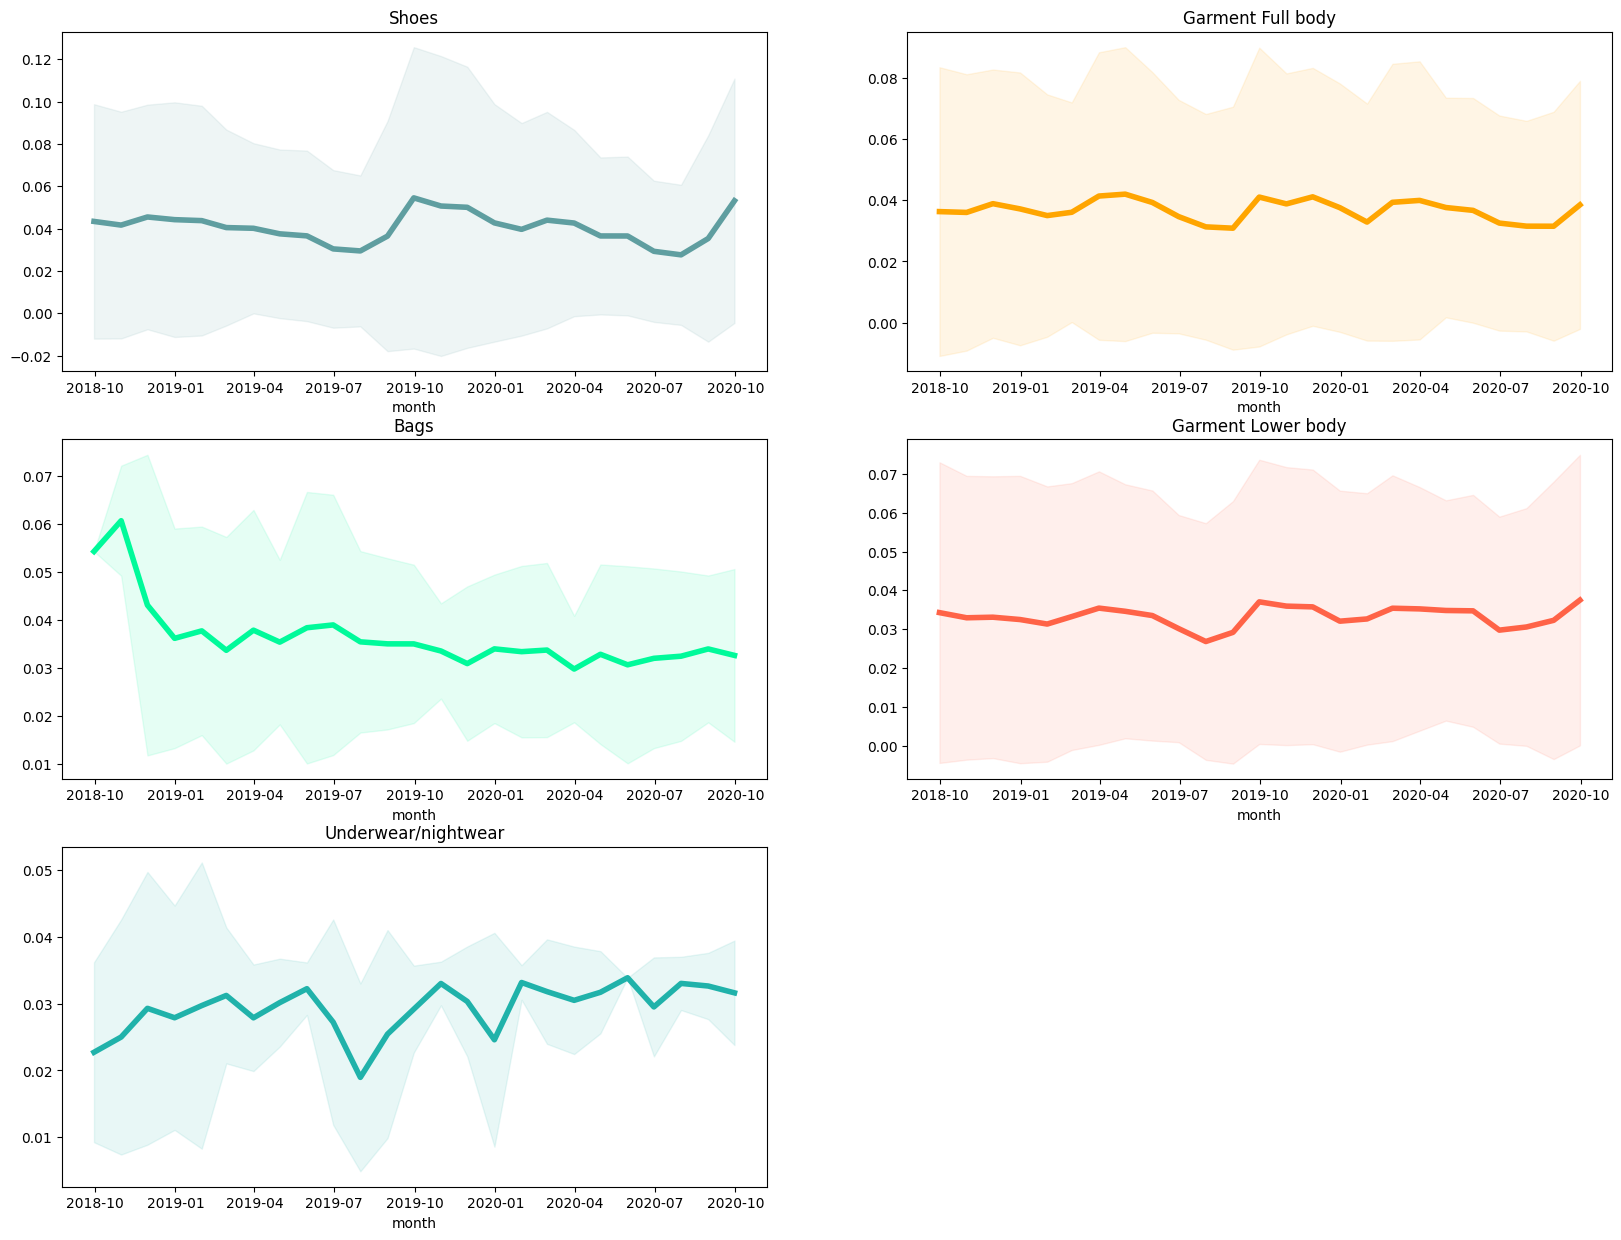

In [130]:
k = 0
f, ax = plt.subplots(3,2,figsize=(20,15))
for i in range(3):
  for j in range(2):
    try:
      product = product_list[k]
      article_for_merge_product = article_for_merge.query('product_group_name==@product')
      result = article_for_merge_product[['t_dat','price']].groupby(pd.Grouper(key='t_dat',freq='M')).agg( \
               mean = ('price','mean'),
                std = ('price','std')
      ).fillna(0)
      ax[i,j].plot(result['mean'],linewidth=4,color=colors[k])
      ax[i,j].fill_between(x=result.index,y1=result['mean']-2*result['std'],y2=result['mean']+2*result['std'],color=colors[k],alpha=0.1)
      ax[i,j].set_title(f'{product}')
      ax[i,j].set_xlabel('month')
      k += 1
    except IndexError:
      ax[i,j].set_visible(False)
plt.show()